## Character-level recurrent sequence-to-sequence model

Example from https://keras.io/examples/nlp/lstm_seq2seq/  
Older post https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import pandas as pd
import pydot as pyd
from itertools import chain

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras 
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, GRU, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

In [4]:
with np.load('data/ncbi_03/dataset.npz', allow_pickle = True) as data:
    encoder_input_data = data['encoder_input_data']
    decoder_input_data = data['decoder_input_data']
    token_index = data['token_index'].tolist()

In [6]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(token_index)

(25865, 3813, 4)
(25865, 3813, 4)
{'A': 0, 'C': 1, 'G': 2, 'T': 3}


In [8]:
X_data = encoder_input_data#[:1000]
Y_data = decoder_input_data#[:1000]
print("X_data", X_data.shape)
print("Y_data", Y_data.shape)

X_data (25865, 3813, 4)
Y_data (25865, 3813, 4)


In [9]:
reverse_char_index = dict((i, char) for char, i in token_index.items())
decode_seq = lambda seq: [ ''.join([ reverse_char_index[i] for i in s ]) for s in np.argmax(seq, axis = 2)]

In [10]:
i = 5
print(decode_seq(X_data[i:i+1])[0])
print(decode_seq(Y_data[i:i+1])[0])

ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATCTTACAACCAGAACTCAATTACCCCCTGCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACATTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATCTCTGGGACCAATGGTACTAAGAGGTTTGATAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAACGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATGATCCATTTTTGGGTGTTTACCACAAAAACAACAAAAGTTGGATGGAAAGTGAGTTCAGAGTTTATTCTAGTGCGAATAATTGCACTTTTGAATATGTCTCTCAGCCTTTTCTTATGGACCTTGAAGGAAAACAGGGTAATTTCAAAAATCTTAGGGAATTTGTGTTTAAGAATATTGATGGTTATTTTAAAATATATTCTAAGCACACGCCTATTAATTTAGTGCGTGATCTCCCTCAGGGTTTTTCGGCTTTAGAACCATTGGTAGATTTGCCAATAGGTATTAACATCACTAGGTTTCAAACTTTACTTGCTTTACATAGAAGTTATTTGACTCCTGGTGATTCTTCTTCAGGTTGGACAGCTGGTGCTGCAGCTTATTATGTGGGTTATCTTCAACCTAGGACTTTTCTATTAAAATATAATGAAAATGGAACCATTACAGATGCTGTAGACTGTGCACTTGACCCTCTCTCAGAAACAAAGTGTACGTTGAAATCCTTCACTGTAGAAAAAGGAATCTATCAAACTTCTAACTTTAGAGTCCAACCAACAGAATCTATTGTTAGATTTCCTAATATTACAAACTTGTGCC

In [11]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 560354617765453049
xla_global_id: -1
]


## Construct model

In [66]:
n_hidden = 24
n_length = 41
n_splits = X_data.shape[1] // n_length
n_splits

93

In [67]:
input_train = Input(shape=(X_data.shape[1], X_data.shape[2]))
input_rand_rate = Input(shape=())
output_train = Input(shape=(Y_data.shape[1], Y_data.shape[2]))

print(input_train)
print(input_rand_rate)
print(output_train)

KerasTensor(type_spec=TensorSpec(shape=(None, 3813, 4), dtype=tf.float32, name='input_16'), name='input_16', description="created by layer 'input_16'")
KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.float32, name='input_17'), name='input_17', description="created by layer 'input_17'")
KerasTensor(type_spec=TensorSpec(shape=(None, 3813, 4), dtype=tf.float32, name='input_18'), name='input_18', description="created by layer 'input_18'")


In [68]:
splits = tf.split(input_train, num_or_size_splits=n_splits, axis=1)
concat = tf.concat(splits, axis=0)
print(concat)

KerasTensor(type_spec=TensorSpec(shape=(None, 41, 4), dtype=tf.float32, name=None), name='tf.concat_6/concat:0', description="created by layer 'tf.concat_6'")


In [69]:
encoder_stack_h, encoder_last_h = GRU(
    n_hidden, dropout = 0.01, recurrent_dropout = 0.01,
    return_sequences = True, return_state = True)(concat)
print(encoder_stack_h)
print(encoder_last_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 41, 24), dtype=tf.float32, name=None), name='gru_6/transpose_1:0', description="created by layer 'gru_6'")
KerasTensor(type_spec=TensorSpec(shape=(None, 24), dtype=tf.float32, name=None), name='gru_6/while:4', description="created by layer 'gru_6'")


In [70]:
encoder_last_h = BatchNormalization(momentum = 0.6)(encoder_last_h)
decoder_input = RepeatVector(concat.shape[1])(encoder_last_h)
print(decoder_input)

KerasTensor(type_spec=TensorSpec(shape=(None, 41, 24), dtype=tf.float32, name=None), name='repeat_vector_3/Tile:0', description="created by layer 'repeat_vector_3'")


In [71]:
decoder_stack_h = GRU(n_hidden, dropout = 0.01, recurrent_dropout = 0.01,
 return_state = False, return_sequences = True)(
 decoder_input, initial_state = encoder_last_h)
print(decoder_stack_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 41, 24), dtype=tf.float32, name=None), name='gru_7/transpose_1:0', description="created by layer 'gru_7'")


In [72]:
attention = dot([decoder_stack_h, encoder_stack_h], axes = [2, 2])
attention = Activation('softmax')(attention)
print(attention)

KerasTensor(type_spec=TensorSpec(shape=(None, 41, 41), dtype=tf.float32, name=None), name='activation_3/Softmax:0', description="created by layer 'activation_3'")


In [73]:
class RandomDropout(keras.layers.Layer):
    
    def call(self, inputs, rate):
        return tf.nn.dropout(inputs, rate=rate[0])
    

In [74]:
context = dot([attention, encoder_stack_h], axes = [2,1])
context = BatchNormalization(momentum = 0.6)(context)
context = RandomDropout()(context, input_rand_rate)
print(context)

KerasTensor(type_spec=TensorSpec(shape=(None, 41, 24), dtype=tf.float32, name=None), name='random_dropout_3/dropout/Mul:0', description="created by layer 'random_dropout_3'")


In [75]:
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

KerasTensor(type_spec=TensorSpec(shape=(None, 41, 48), dtype=tf.float32, name=None), name='concatenate_3/concat:0', description="created by layer 'concatenate_3'")


In [76]:
out = TimeDistributed(Dense(concat.shape[2], activation = "softmax"))(decoder_combined_context)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 41, 4), dtype=tf.float32, name=None), name='time_distributed_3/Reshape_1:0', description="created by layer 'time_distributed_3'")


In [77]:
back_splits = tf.split(out, num_or_size_splits=n_splits, axis=0)
back_concat = tf.concat(back_splits, axis=1)
print(back_concat)

KerasTensor(type_spec=TensorSpec(shape=(None, 3813, 4), dtype=tf.float32, name=None), name='tf.concat_7/concat:0', description="created by layer 'tf.concat_7'")


In [78]:
model = Model(inputs = [input_train, input_rand_rate], outputs = back_concat)
opt = keras.optimizers.Adam(learning_rate = 0.01, clipnorm = 1)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 3813, 4)]    0           []                               
                                                                                                  
 tf.split_6 (TFOpLambda)        [(None, 41, 4),      0           ['input_16[0][0]']               
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                             

                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
          

                                                                  'tf.split_6[0][67]',            
                                                                  'tf.split_6[0][68]',            
                                                                  'tf.split_6[0][69]',            
                                                                  'tf.split_6[0][70]',            
                                                                  'tf.split_6[0][71]',            
                                                                  'tf.split_6[0][72]',            
                                                                  'tf.split_6[0][73]',            
                                                                  'tf.split_6[0][74]',            
                                                                  'tf.split_6[0][75]',            
                                                                  'tf.split_6[0][76]',            
          

                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
          

                                                                  'tf.split_7[0][12]',            
                                                                  'tf.split_7[0][13]',            
                                                                  'tf.split_7[0][14]',            
                                                                  'tf.split_7[0][15]',            
                                                                  'tf.split_7[0][16]',            
                                                                  'tf.split_7[0][17]',            
                                                                  'tf.split_7[0][18]',            
                                                                  'tf.split_7[0][19]',            
                                                                  'tf.split_7[0][20]',            
                                                                  'tf.split_7[0][21]',            
          

Total params: 6,148
Trainable params: 6,052
Non-trainable params: 96
__________________________________________________________________________________________________


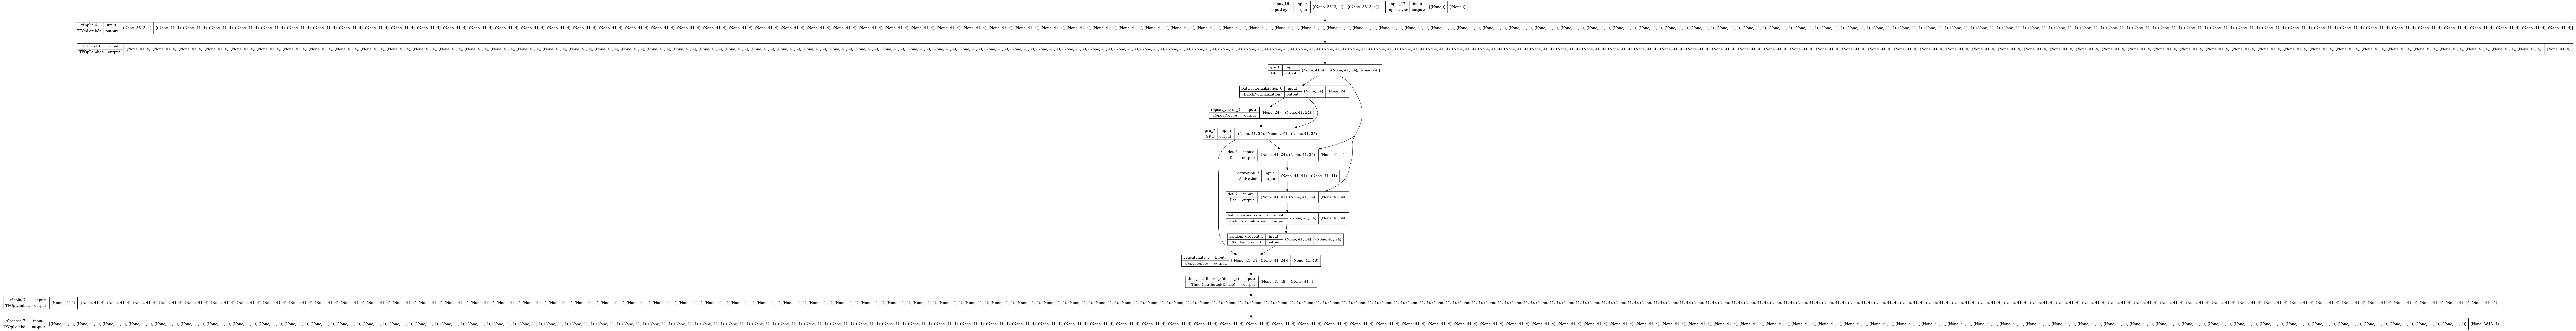

In [79]:
keras.utils.plot_model(model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)

## Train model

In [80]:
batch_size = 64      # Batch size for training.
patience = 10        # Patience for EarlyStop
epochs = 500         # Number of epochs to train for.
rand_rate = np.full((len(X_data)), 0.05)

In [81]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = patience, restore_best_weights = True)
history = model.fit([ X_data, rand_rate ], Y_data, 
                    validation_split = 0.2, 
                    epochs = epochs, verbose = 1, callbacks = [ es ], 
                    batch_size = batch_size)

# train_mae = history.history['accuracy']
# valid_mae = history.history['val_accuracy']

Epoch 1/500
324/324 [==============================] - 158s 476ms/step - loss: 1.2038 - accuracy: 0.4417 - val_loss: 1.0037 - val_accuracy: 0.5507
Epoch 2/500
324/324 [==============================] - 152s 470ms/step - loss: 1.0077 - accuracy: 0.5462 - val_loss: 0.8609 - val_accuracy: 0.6225
Epoch 3/500
324/324 [==============================] - 152s 470ms/step - loss: 0.9433 - accuracy: 0.5773 - val_loss: 0.7976 - val_accuracy: 0.6564
Epoch 4/500
324/324 [==============================] - 152s 470ms/step - loss: 0.9122 - accuracy: 0.5911 - val_loss: 0.7565 - val_accuracy: 0.6776
Epoch 5/500
324/324 [==============================] - 152s 469ms/step - loss: 0.8887 - accuracy: 0.6023 - val_loss: 0.7232 - val_accuracy: 0.6931
Epoch 6/500
324/324 [==============================] - 153s 472ms/step - loss: 0.8701 - accuracy: 0.6109 - val_loss: 0.7054 - val_accuracy: 0.6998
Epoch 7/500
324/324 [==============================] - 152s 468ms/step - loss: 0.8580 - accuracy: 0.6164 - val_loss: 0

324/324 [==============================] - 154s 475ms/step - loss: 0.7589 - accuracy: 0.6662 - val_loss: 0.5700 - val_accuracy: 0.7729
Epoch 57/500
324/324 [==============================] - 152s 470ms/step - loss: 0.7580 - accuracy: 0.6666 - val_loss: 0.5659 - val_accuracy: 0.7722
Epoch 58/500
324/324 [==============================] - 153s 472ms/step - loss: 0.7576 - accuracy: 0.6668 - val_loss: 0.5732 - val_accuracy: 0.7716
Epoch 59/500
324/324 [==============================] - 152s 469ms/step - loss: 0.7568 - accuracy: 0.6672 - val_loss: 0.5638 - val_accuracy: 0.7756
Epoch 60/500
324/324 [==============================] - 153s 471ms/step - loss: 0.7570 - accuracy: 0.6671 - val_loss: 0.5554 - val_accuracy: 0.7814
Epoch 61/500
324/324 [==============================] - 152s 468ms/step - loss: 0.7566 - accuracy: 0.6673 - val_loss: 0.5614 - val_accuracy: 0.7772
Epoch 62/500
324/324 [==============================] - 153s 471ms/step - loss: 0.7557 - accuracy: 0.6677 - val_loss: 0.5572 

324/324 [==============================] - 151s 466ms/step - loss: 0.7399 - accuracy: 0.6760 - val_loss: 0.5415 - val_accuracy: 0.7854
Epoch 112/500
324/324 [==============================] - 150s 462ms/step - loss: 0.7396 - accuracy: 0.6761 - val_loss: 0.5407 - val_accuracy: 0.7881
Epoch 113/500
324/324 [==============================] - 150s 462ms/step - loss: 0.7389 - accuracy: 0.6764 - val_loss: 0.5343 - val_accuracy: 0.7921
Epoch 114/500
324/324 [==============================] - 149s 461ms/step - loss: 0.7386 - accuracy: 0.6765 - val_loss: 0.5361 - val_accuracy: 0.7883
Epoch 115/500
324/324 [==============================] - 150s 464ms/step - loss: 0.7389 - accuracy: 0.6765 - val_loss: 0.5361 - val_accuracy: 0.7874
Epoch 116/500
324/324 [==============================] - 149s 460ms/step - loss: 0.7384 - accuracy: 0.6768 - val_loss: 0.5363 - val_accuracy: 0.7888
Epoch 117/500
324/324 [==============================] - 151s 465ms/step - loss: 0.7381 - accuracy: 0.6769 - val_loss: 0

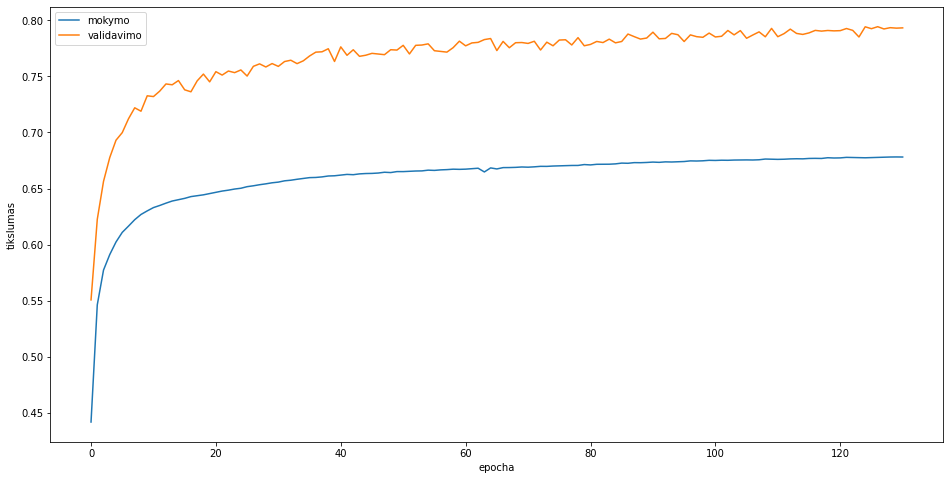

In [82]:
plt.plot(history.history['accuracy'], label = 'mokymo')
plt.plot(history.history['val_accuracy'], label = 'validavimo')
plt.ylabel('tikslumas')
plt.xlabel('epocha')
plt.legend()
plt.show()

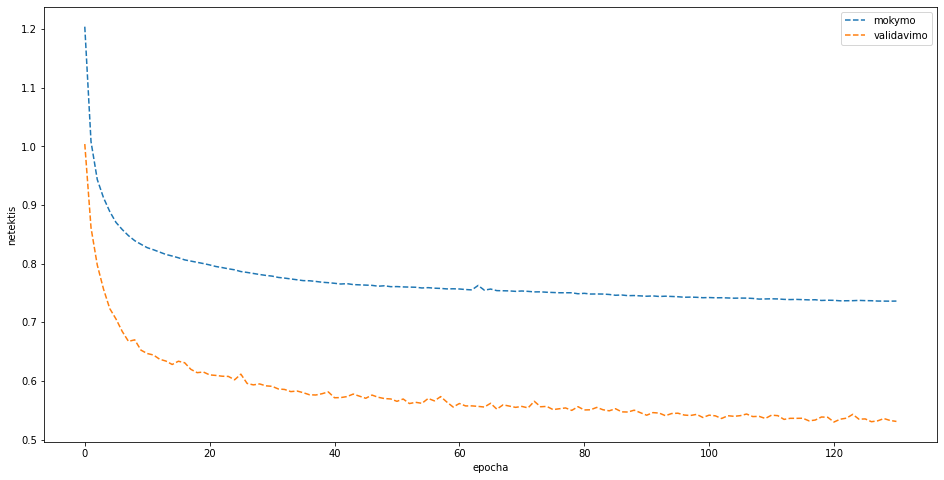

In [83]:
plt.plot(history.history['loss'], '--', label = 'mokymo')
plt.plot(history.history['val_loss'], '--', label = 'validavimo')
plt.ylabel('netektis')
plt.xlabel('epocha')
plt.legend()
plt.show()

In [84]:
model.save("data/ncbi_03/model_gru_32_24")

INFO:tensorflow:Assets written to: data/ncbi_03/model_gru_32_24/assets


INFO:tensorflow:Assets written to: data/ncbi_03/model_gru_32_24/assets
